
# Teeth Classification using Transfer Learning

This project applies transfer learning to a teeth image classification dataset.

## Approach
We use **EfficientNetB3** pre-trained on ImageNet as the base model.

### Why EfficientNetB3?
- Excellent accuracy-to-parameter ratio
- Fast convergence
- Strong performance on small/medium datasets
- Proven results in medical-style image classification

### Dataset
The dataset is structured into:
- Training
- Validation
- Testing

Target accuracy: **> 0.97540**


In [ ]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

tf.random.set_seed(42)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Extract Testing Dataset and Remove Unwanted Folders

After extracting the testing zip file, the following folders are removed to match
Training and Validation structure:

- output
- outputs
- output_image


In [4]:

zip_path = "/content/drive/MyDrive/Teeth_Dataset.zip"
extract_path = "/content/Teeth_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

unwanted_dirs = ["output", "outputs", "output_image"]

for folder in unwanted_dirs:
    folder_path = os.path.join(extract_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

print("Extraction complete and unwanted folders removed.")


Extraction complete and unwanted folders removed.



## Data Loading and Preprocessing

Steps:
- Batch processing
- Shuffle training set
- Apply data augmentation
- Normalize using EfficientNet preprocessing


In [6]:

train_dir = "/content/Teeth_Dataset/Teeth_Dataset/Training"
val_dir = "/content/Teeth_Dataset/Teeth_Dataset/Validation"
test_dir = "/content/Teeth_Dataset/Teeth_Dataset/Testing"

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


## Transfer Learning Strategy
- two-phase transfer learning approach
- Base model: EfficientNetB3 (ImageNet weights)
- Freeze base layers initially
- Add GlobalAveragePooling + Dropout + Dense output
- Fine-tune top


In [8]:
base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,738,678 (44.78 MB)

 Trainable params: 953,607 (3.64 MB)

 Non-trainable params: 10,785,071 (41.14 MB)

In [9]:

callbacks = [
    ModelCheckpoint("teeth_model_v1.keras", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]


In [10]:
from sklearn.utils.class_weight import compute_class_weight

labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 337ms/step - accuracy: 0.2866 - loss: 2.1983 - val_accuracy: 0.5817 - val_loss: 1.1800 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.5000 - loss: 1.4217 - val_accuracy: 0.6829 - val_loss: 0.8903 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.5800 - loss: 1.2156 - val_accuracy: 0.7364 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.6115 - loss: 1.0924 - val_accuracy: 0.7510 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.6515 - loss: 0.9505 - val_accuracy: 0.7860 - val_loss: 0.5785 - learning_rate: 0.0010
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - accuracy: 0.6679 - loss: 0.8881 - val_accuracy: 0.7850 - val_loss: 0.5480 - learning_rate: 0.0010
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.7184 - loss: 0.

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

phase2_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.6294 - loss: 1.0642 - val_accuracy: 0.8658 - val_loss: 0.3483 - learning_rate: 1.0000e-04
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.7554 - loss: 0.6857 - val_accuracy: 0.9056 - val_loss: 0.2632 - learning_rate: 1.0000e-04
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.8008 - loss: 0.5784 - val_accuracy: 0.9329 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.8294 - loss: 0.4505 - val_accuracy: 0.9523 - val_loss: 0.1484 - learning_rate: 1.0000e-04
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.8615 - loss: 0.3737 - val_accuracy: 0.9591 - val_loss: 0.1192 - learning_rate: 1.0000e-04
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 309ms/step - accuracy: 0.8914 - loss: 0.3126 - val_accuracy: 0.9796 - val_loss: 0.0811 - learning_rate: 1.0000e-04
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 28s 291ms/step - acc

## Evaluation on Test Set

In [13]:

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_accuracy:.5f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.9990 - loss: 0.0045
Final Test Accuracy: 0.99708


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

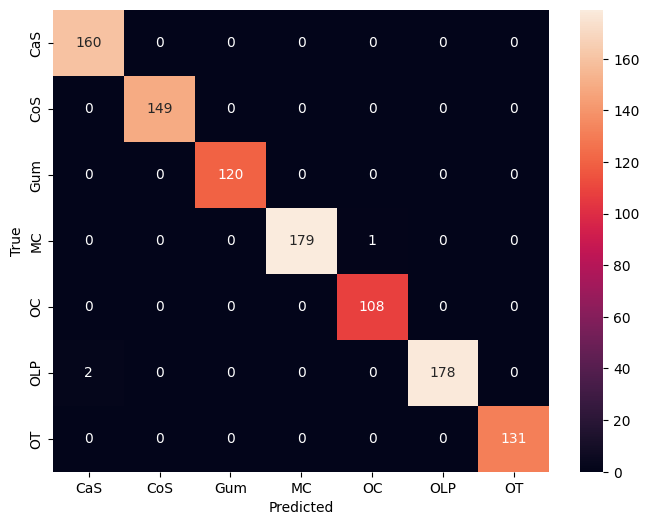

              precision    recall  f1-score   support

         CaS       0.99      1.00      0.99       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       1.00      0.99      1.00       180
          OC       0.99      1.00      1.00       108
         OLP       1.00      0.99      0.99       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028



In [14]:

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


In [15]:

model.save("teeth_transfer_learning_final_v1.keras")
